# Prueba de Verosimilitud Logarítmica

En este cuaderno se realizará la implementación de una prueba de verosimilitud logarítmica orientada a generar resúmenes.

Para la implementación de esta técnica, se realizarán las siguientes fases:

1. Cargar datos.
2. Aplicar el preprocesamiento al nuevo corpus.
3. Crear diccionarios para relacionar frases e identificadores 
4. Calcular matriz de verosimilitud logarítmica
5. Determinar umbral (Determinar topic signatures).
6. Ajustar topic signatures a un solo texto.
7. Seleccionar frases
8. Evaluar el resumen obtenido

In [1]:
#Importar elementos necesarios de las librerías
import os, shutil, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.corpus import PlaintextCorpusReader
from nltk.stem.snowball import SpanishStemmer
from scipy.stats import binom, chi2
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

In [2]:
#Funciones auxiliares

def tokenize_sentence(path, file_name):
    #Retorna un documento tokenizado por frases
    doc = []
    text = PlaintextCorpusReader(path, file_name)
    paragraphs = text.paras()
    for paragraph in paragraphs:
        for sentence in paragraph:
            low, i = 0,0
            while i < len(sentence):
                token = sentence[i].split('.')
                if len(token)-1:
                    doc.append(sentence[low:i])
                    low=i+1
                    i+=2
                else:
                    i+=1
            if low!=i-1:
                doc.append(sentence[low:i])
    return doc

def preprocess(doc, stopwords, stemmer):
    #Aplica el preprocesamiento establecido
    #Adicionalmente, retorna el documento original sin las filas vacías por el preprocesamiento 
    doc_preprocesed, doc_reduced = [], []
    for original_sentence in doc:
        preprocessed_sentence = []
        for token in original_sentence:
            if stemmer.stem(token) not in stopwords:
                preprocessed_sentence.append(stemmer.stem(token))
        if len(preprocessed_sentence) and preprocessed_sentence not in doc_preprocesed:
            doc_preprocesed.append(preprocessed_sentence)
            doc_reduced.append(original_sentence)
    return doc_preprocesed, doc_reduced

def get_dictionaries(doc):
    #Retorna un par de diccionarios que relacionan una frase con un id, y un id con una frase.
    sentence2id, id2sentence = {},{}
    n_sentences = len(doc)
    for i in range(n_sentences):
        sentence = ' '.join(doc[i])
        if sentence not in sentence2id:
            sentence2id[sentence] = i
            id2sentence[i] = sentence
    return sentence2id, id2sentence

def reverse_dict(dictionary):
    #Invierte el sentido de un diccionario
    reverse = {}
    for k,v in dictionary.items():
        reverse[v] = k
    return reverse

def log_likelihood_ratio(bag_of_words):
    #Calcula la matriz -2 lambda
    tokens_per_document = bag_of_words.sum(1)
    ocurrences = bag_of_words.sum(0)
    total_tokens = bag_of_words.sum(0).sum(1)[0,0]
    n_documents,m_tokens = bag_of_words.shape
    loglikelihood_general = []
    for i in range(m_tokens):
        ocurrences_general = ocurrences[0,i]
        loglikelihood = binom.pmf(ocurrences_general, total_tokens,ocurrences_general/total_tokens)
        loglikelihood_general.append(loglikelihood)
    data = []
    for i in range(n_documents):
        row = []
        tokens_input = tokens_per_document[i,0]
        tokens_background = total_tokens - tokens_input
        for j in range(m_tokens):
            ocurrences_total = ocurrences[0,j]
            ocurrences_input = bag_of_words[i,j]
            ocurrences_background = ocurrences_total - ocurrences_input
            loglikelihood_input = binom.pmf(ocurrences_input, tokens_input, ocurrences_input/tokens_input)
            loglikelihood_background = binom.pmf(ocurrences_background, tokens_background, ocurrences_background/tokens_background)
            ratio = loglikelihood_general[j]/(loglikelihood_input*loglikelihood_background)
            row.append(ratio)
        data.append(row)
    lambda_matrix = np.array(data,dtype=np.float64)
    lambda_log_matrix = np.log(data)
    lambda_matrix_2 = lambda_matrix*-2
    lambda_log_matrix_2 = lambda_log_matrix*-2
    return lambda_matrix, lambda_log_matrix, lambda_matrix_2, lambda_log_matrix_2
    #Corregir posteriormente para solo retornar una de estas

def corpus_topic_signatures(log_likelihood_matrix, treshold):
    #Crea una matriz con los topic signatures a partir de la matriz -2lambda y el umbral
    data, col_index, row_index = [],[],[]
    n_documents, m_tokens = log_likelihood_matrix.shape
    for i in range(n_documents):
        for j in range(m_tokens):
            if log_likelihood_matrix[i,j] >= treshold:
                row_index.append(i)
                col_index.append(j)
                data.append(1)
    data = np.array(data)
    row_index = np.array(row_index)
    col_index = np.array(col_index)
    topic_signatures = csr_matrix((data,(row_index,col_index)),shape=(n_documents, m_tokens),dtype=np.float64)
    return topic_signatures

def document_topic_signatures(document, topic_signatures, token2id, doc_id):
    #Construye una matriz de un solo documento de acuerdo a la matriz de topic signatures 
    data,row_index,col_index = [],[],[]
    topic_signatures = topic_signatures.toarray()
    n_sentences, m_tokens = len(document), len(token2id)
    for i in range(n_sentences):
        sentence = document[i]
        j = 0
        for token in sentence:
            if token in token2id and topic_signatures[doc_id,token2id[token]] == 1:
                if (j==0) or (j>0 and token2id[token] not in col_index[-j:]):
                    topic_signature_value = topic_signatures[doc_id,token2id[token]]
                    data.append(topic_signature_value)
                    row_index.append(i)
                    col_index.append(token2id[token])
                    j+=1
    data = np.array(data)
    row_index = np.array(row_index)
    col_index = np.array(col_index)
    topic_signatures_document = csr_matrix((data,(row_index,col_index)),shape=(n_sentences, m_tokens),dtype=np.float64)
    return topic_signatures_document

def generate_summary(topic_signatures, n_sentences, sentence2id):
    #Genera un resumen con un total de n_sentences frases
    total_sentences = topic_signatures.shape[0]
    assert n_sentences < total_sentences
    topic_signatures = topic_signatures.toarray().sum(1)
    df = pd.DataFrame(topic_signatures,columns = ['topic signatures'])
    df['sentence'] = sentence2id.keys()
    df = df.sort_values(by='topic signatures', ascending = False)
    summary = []
    i,flag=0,1
    while i < n_sentences and flag:
        sentence = df.iloc[i]['sentence']
        flag = df.iloc[i]['topic signatures']
        if flag:
            summary.append(sentence)
        i+=1
    assert summary != []
    return summary, df

def read_reference(path, filename):
    text = PlaintextCorpusReader(path, filename)
    text = text.paras()
    flat = []
    for sentences in text:
        for sentence in sentences:
            flat_sentence = ' '.join(sentence)
            flat.append(flat_sentence)
    reference = ' '.join(flat)
    return reference

## Fase 1. Cargar datos

In [3]:
#Cargar las stopwords obtenido en preprocesamiento.
filename = 'stopwords.pkl'
stopwords = pickle.load(open(filename, 'rb'))

#Carga el corpus usado para el preprocesamiento
filename = 'corpus_single_string.pkl'
corpus_single_string = pickle.load(open(filename, 'rb'))

## Fase 2. Aplicar preprocesamiento
### Tokenización por frases

In [4]:
ruta = "D:/Documents/Documentos Universidad/Noveno/Proyecto de grado/textos"
stemmer = SpanishStemmer()

corpus = []

referencias = ['azure-pagos.txt','chrome-privacidad.txt','colboletos.txt','gdo-privacidad.txt',
               'mozilla-privacidad.txt','nintendo-condiciones.txt','netflix-condiciones.txt',
               'segurosbolivar-privacidad.txt','whatsApp-privacidad.txt']
n_referencias = len(referencias)

for doc in referencias:
    documento = tokenize_sentence(ruta, doc)
    corpus.append(documento)

#bolivar = tokenize_sentence(ruta, 'segurosbolivar-privacidad.txt')
#mozilla = tokenize_sentence(ruta, 'mozilla-privacidad.txt')

### Stopwords y Stemming

In [5]:
corpus_preprocesado = []
for i in range(n_referencias):
    doc_preprocesado, corpus[i] = preprocess(corpus[i], stopwords, stemmer)
    corpus_preprocesado.append(doc_preprocesado)
    
#bolivar_preprocesado, bolivar = preprocess(bolivar, stopwords, stemmer)
#mozilla_preprocesado, mozilla = preprocess(mozilla, stopwords, stemmer)

## Fase 3. Crear diccionarios para relacionar frases e identificadores 

In [6]:
frase2id, id2frase = [],[]

for i in range(n_referencias):
    f2id, id2f = get_dictionaries(corpus[i])
    frase2id.append(f2id)
    id2frase.append(id2f)

#frase2id_bolivar, id2frase_bolivar = get_dictionaries(bolivar)
#frase2id_mozilla, id2frase_mozilla = get_dictionaries(mozilla)

## Fase 4. Calcular matriz de verosimilitud logarítmica

In [7]:
vectorizer = CountVectorizer(stop_words = stopwords)

bag_of_words = vectorizer.fit_transform(corpus_single_string)

#Diccionario que relaciona tokens con un identificador único
token2id = vectorizer.vocabulary_

#Diccionario que un identificador con un token
id2token = reverse_dict(token2id)

#bag_of_words = vectorizer.fit_transform(corpus)

In [8]:
lambda_matrix, lambda_log_matrix, lambda_matrix_2, lambda_log_matrix_2 = log_likelihood_ratio(bag_of_words)

#log_likelihood, general, ocurrences = log_likelihood_ratio(bag_of_words)
#log_likelihood
#Pruebas
#general[token2id['acced']]

In [9]:
#Sin multiplicar por -2 (Pruebas)
lambda_matrix[38,token2id['acced']]

3.6763415495439085

In [10]:
#Multiplicando por -2 (Pruebas)
lambda_matrix[38,token2id['acced']]

3.6763415495439085

In [11]:
lambda_matrix.shape

(56, 4740)

## Fase 5. Determinar umbral (Determinar topic signatures). 

In [12]:
umbrales = [5.0239,6.6349,7.8794,10.8276]

topic_signatures_umbrales = []

for umbral in umbrales:
    topic_signatures = corpus_topic_signatures(lambda_matrix,umbral)
    topic_signatures_umbrales.append(topic_signatures)

#topic_signatures_0_025 = corpus_topic_signatures(lambda_matrix,5.0239)
#topic_signatures_0_010 = corpus_topic_signatures(lambda_matrix,6.6349)
#topic_signatures_0_005 = corpus_topic_signatures(lambda_matrix,7.8794)
#topic_signatures_0_001 = corpus_topic_signatures(lambda_matrix,10.8276)


#topic_signatures_0_025.toarray()

In [13]:
#topic_signatures_0_025.shape

### Comprobar cantidad de topic signatures encontradas dentro del corpus

In [14]:
#Pruebas para mirar la cantidad de topic signatures dentro de todo el corpus de acuerdo al umbral establecido

for i in range(len(umbrales)):
    print('umbral: ',umbrales[i])
    print(topic_signatures_umbrales[i].toarray().sum(1))
    print()

#topic_signatures_0_025.toarray().sum(1)

umbral:  5.0239
[230. 158. 108. 143. 148.  56. 142. 440. 220. 147.  36.  29. 114. 131.
 166. 102. 118. 136.  14.  10. 109. 228. 136. 135. 189.  18.  79. 158.
  97.  49.  64. 205. 156.  94. 149. 327. 204. 101.  29. 264. 154. 261.
 148.  44. 180. 171. 126. 112.  41. 262. 198. 214. 182. 134. 105. 193.]

umbral:  6.6349
[110.  85.  48.  76.  80.  21.  53. 278. 114.  68.  12.   6.  60.  68.
  80.  51.  63.  66.   3.   4.  41. 110.  58.  71. 106.   2.  41.  80.
  43.  23.  25. 111.  86.  37.  71. 183.  96.  43.   8. 152.  78. 149.
  72.  20.  81.  67.  53.  48.  14. 147. 118. 109.  99.  65.  56. 105.]

umbral:  7.8794
[ 65.  50.  31.  47.  50.  10.  29. 199.  74.  40.   6.   3.  37.  49.
  51.  23.  43.  42.   2.   1.  23.  84.  32.  43.  71.   2.  20.  52.
  25.  16.  16.  71.  57.  24.  41. 117.  56.  25.   3. 103.  47.  89.
  41.  13.  51.  33.  31.  30.   8. 104.  80.  70.  69.  41.  34.  68.]

umbral:  10.8276
[32. 17. 11. 19. 27.  3.  8. 93. 27. 14.  1.  0. 10. 20. 19.  9.  8. 19.
  0.

In [15]:
umbrales.pop()
topic_signatures_umbrales.pop()

<56x4740 sparse matrix of type '<class 'numpy.float64'>'
	with 972 stored elements in Compressed Sparse Row format>

## Fase 6. Ajustar topic signatures a un solo texto.

In [16]:
#Lista de textos dentro del corpus
textos = os.listdir(ruta)

topic_signatures_corpus = []

for i in range(n_referencias):
    topic_signatures_texto = []
    for j in range(len(umbrales)):
        topic_signatures = document_topic_signatures(corpus_preprocesado[i], topic_signatures_umbrales[j], token2id, textos.index(referencias[i]))
        topic_signatures_texto.append(topic_signatures)
    topic_signatures_corpus.append(topic_signatures_texto)

#topic_signatures_bolivar_0_025 = document_topic_signatures(bolivar_preprocesado, topic_signatures_0_025, token2id, textos.index('segurosbolivar-privacidad.txt'))
#topic_signatures_bolivar_0_010 = document_topic_signatures(bolivar_preprocesado, topic_signatures_0_010, token2id, textos.index('segurosbolivar-privacidad.txt'))
#topic_signatures_bolivar_0_005 = document_topic_signatures(bolivar_preprocesado, topic_signatures_0_005, token2id, textos.index('segurosbolivar-privacidad.txt'))
#topic_signatures_bolivar_0_025.shape

## Fase 7. Seleccionar frases

In [29]:
resumenes_corpus,df_corpus = [],[]

for i in range(n_referencias):
    resumen_texto,df_texto = [],[]
    for j in range(len(umbrales)):
        resumen, df = generate_summary(topic_signatures_corpus[i][j], 5, frase2id[i])
        resumen = ' '.join(resumen)
        resumen_texto.append(resumen)
        df_texto.append(df)
    resumenes_corpus.append(resumen_texto)
    df_corpus.append(df_texto)

#resumen_0_025, df_0_025 = generate_summary(topic_signatures_bolivar_0_025, 5, frase2id_bolivar)
#resumen_0_010, df_0_010 = generate_summary(topic_signatures_bolivar_0_010, 5, frase2id_bolivar)
#resumen_0_005, df_0_005 = generate_summary(topic_signatures_bolivar_0_005, 5, frase2id_bolivar)

### Dataframes

In [20]:
#df_0_025.head(10)

,topic signatures,sentence
17,12.0,LAS COMPAÑÍAS han identificado los datos que a...
8,9.0,"com , ponemos a su disposición el presente Avi..."
26,7.0,"Declaro que , con base en dicho conocimiento ,..."
43,7.0,Solicitar prueba de la autorización otorgada a...
31,6.0,"Enviar material publicitario , o promocional s..."
40,5.0,Como Titular de datos personales usted tiene l...
22,5.0,"LAS COMPAÑÍAS hacen parte del Grupo Bolívar , ..."
0,5.0,Políticas de privacidad de Seguros Bolívar Avi...
42,5.0,"Este derecho se podrá ejercer , entre otros fr..."
44,5.0,Ser informado por el Responsable del Tratamien...


### Resumenes

In [22]:
#resumenes_corpus[referencias.index('segurosbolivar-privacidad.txt')][0]
#resumen_0_025

['com , ponemos a su disposición el presente Aviso de Privacidad que busca informar al Titular de datos personales acerca de la existencia de las Políticas de Tratamiento de información que han sido adoptadas por LAS COMPAÑÍAS , la forma de acceder a éstas y las características del Tratamiento que se le pretende dar a los datos',
 'LAS COMPAÑÍAS han identificado los datos que administran , así como las actividades que desarrollan con dichos datos , en particular su recepción , conservación , disposición para los fines propios del contrato y desarrollo de actividades complementarias referidas a la promoción y el mercadeo de sus productos y servicios , así como los ofrecidos por las Compañías que hacen parte del Grupo Bolívar , al cual éstas pertenecen y así lo han indicado en las Políticas del Tratamiento disponibles para su consulta en la página web www',
 'Declaro que , con base en dicho conocimiento , autorizo para que LAS COMPAÑÍAS compartan con dichas empresas y entidades la inform

In [35]:
for i in range(n_referencias):
    print(referencias[i])
    print(resumenes_corpus[i][0])
    print()
#      Imprimir resumenes  

azure-pagos.txt
Podemos suspender el uso que usted haga de los Servicios Online si : ( 1 ) es razonablemente necesario para impedir el acceso no autorizado a los Datos del Cliente ; ( 2 ) usted no responde a una reclamación de una supuesta infracción de derechos en virtud de la Cláusula 5 dentro de un plazo razonable ; ( 3 ) no paga los importes debidos en virtud de este contrato ; ( 4 ) no se rige por la Directiva de Uso Aceptable o infringe otros términos de este contrato ; o ( 5 ) en el caso de Ofertas Limitadas , la Suscripción queda inactiva por su falta de acceso de los Servicios Online , tal como se describen en los Detalles de la Oferta no se aplicarán a una reclamación o el laudo que se base en : ( i ) cualquier Solución de Cliente , Datos del Cliente , Productos que no son de Microsoft , modificaciones que haga al Producto o servicios o materiales que ponga a disposición como parte de uso del Producto ; ( ii ) su combinación del Producto con , o los daños basados en el valor 

## Fase 8. Evaluar el resumen obtenido

In [31]:
ruta_referencia = "D:/Documents/Documentos Universidad/Noveno/Proyecto de grado/referencias"

resumenes_referencia = []

for doc in referencias:
    referencia_doc = read_reference(ruta_referencia, doc)
    resumenes_referencia.append(referencia_doc) 
        
#resumen_0_025 = ' '.join(resumen_0_025)
#resumen_0_010 = ' '.join(resumen_0_010)
#resumen_0_005 = ' '.join(resumen_0_005)

rouge = Rouge(metrics=["rouge-1", "rouge-l"])

In [33]:
for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(umbrales)):
        print(umbrales[j])
        print(rouge.get_scores(resumenes_corpus[i][j], resumenes_referencia[i]))
    print()

azure-pagos.txt
5.0239
[{'rouge-1': {'f': 0.6630434733988971, 'p': 0.7951582867783985, 'r': 0.5685752330226365}, 'rouge-l': {'f': 0.49152541891877344, 'p': 0.6105263157894737, 'r': 0.41134751773049644}}]
6.6349
[{'rouge-1': {'f': 0.6630434733988971, 'p': 0.7951582867783985, 'r': 0.5685752330226365}, 'rouge-l': {'f': 0.48728813078318023, 'p': 0.6052631578947368, 'r': 0.4078014184397163}}]
7.8794
[{'rouge-1': {'f': 0.6339920900371636, 'p': 0.7801556420233463, 'r': 0.5339547270306259}, 'rouge-l': {'f': 0.4753747275497618, 'p': 0.6, 'r': 0.39361702127659576}}]

chrome-privacidad.txt
5.0239
[{'rouge-1': {'f': 0.36983470695282084, 'p': 0.7276422764227642, 'r': 0.24792243767313019}, 'rouge-l': {'f': 0.24181359781712977, 'p': 0.40336134453781514, 'r': 0.17266187050359713}}]
6.6349
[{'rouge-1': {'f': 0.38235293751191657, 'p': 0.7913043478260869, 'r': 0.2520775623268698}, 'rouge-l': {'f': 0.3375314819481121, 'p': 0.5630252100840336, 'r': 0.24100719424460432}}]
7.8794
[{'rouge-1': {'f': 0.3481865

## Pruebas
En este espacio estan las celdas para realizar algunas pruebas, además de la gráfica que contiene los valores de -2lambda para un texto de pruebas (términos de privacidad  de seguros bolivar)

In [49]:
#rouge.get_scores(resumen_0_025, referencia_bolivar)

[{'rouge-1': {'f': 0.3838862510252466,
   'p': 0.3360995850622407,
   'r': 0.44751381215469616},
  'rouge-l': {'f': 0.21645021146605212,
   'p': 0.20491803278688525,
   'r': 0.22935779816513763}}]

In [50]:
#rouge.get_scores(resumen_0_010, referencia_bolivar)

[{'rouge-1': {'f': 0.37313432340771274,
   'p': 0.3393665158371041,
   'r': 0.4143646408839779},
  'rouge-l': {'f': 0.2232142807178732,
   'p': 0.21739130434782608,
   'r': 0.22935779816513763}}]

In [30]:
#rouge.get_scores(resumen_0_005, referencia_bolivar)

[{'rouge-1': {'f': 0.40211639712536046,
   'p': 0.38578680203045684,
   'r': 0.4198895027624309},
  'rouge-l': {'f': 0.2095238045310659,
   'p': 0.21782178217821782,
   'r': 0.2018348623853211}}]

In [96]:
tp = topic_signatures_bolivar.toarray().sum(1)
df = pd.DataFrame(tp,columns = ['topic signature value'])
df['sentence'] = frase2id_bolivar.keys()
df = df.sort_values(by='topic signature value', ascending = False)
#df

In [97]:
x_axis = np.arange(0,log_likelihood.shape[1])
y_axis = log_likelihood.tolist()[textos.index('segurosbolivar-privacidad.txt')]

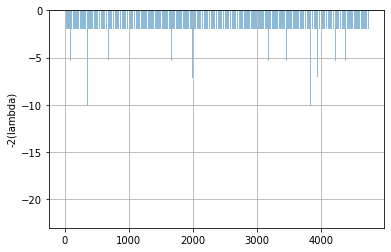

In [98]:
plt.bar(x_axis, y_axis, align='center', alpha=0.5)
plt.ylabel("-2(lambda)")
plt.grid()
plt.show()

In [101]:
data = [[y_axis[i],id2token[i]] for i in range(len(y_axis))]
df = pd.DataFrame(data,columns=['valor','token'])
df = df.sort_values(by='valor', ascending = False).head(10)
df

,valor,token
1176,-21.927381,dat
4443,-18.715980,tratamient
836,-18.122429,compañ
3267,-15.749891,personal
1923,-14.630646,final
537,-14.069663,boliv
2090,-13.572011,grup
2343,-13.307293,inform
75,-13.201412,activ
1270,-13.019640,desarroll


In [95]:
#bag_of_words.sum(0)[0,token2id['acced']]

349

In [67]:
#ocurrences[0,token2id['acced']]

349

In [69]:
#bag_of_words.sum(1).sum(0)[0,0]

146112

In [2]:
np.log([[1,2,3],[4,5,6],[7,8,9]])

array([[0.        , 0.69314718, 1.09861229],
       [1.38629436, 1.60943791, 1.79175947],
       [1.94591015, 2.07944154, 2.19722458]])

### Dataframe con los distintos valores estimados

In [21]:
#Lista de textos dentro del corpus
textos = os.listdir(ruta)

lambda_bolivar = lambda_matrix.tolist()[textos.index('segurosbolivar-privacidad.txt')]
lambda_log_bolivar = lambda_log_matrix.tolist()[textos.index('segurosbolivar-privacidad.txt')]
lambda_bolivar_2 = lambda_matrix_2.tolist()[textos.index('segurosbolivar-privacidad.txt')]
lambda_log_bolivar_2 = lambda_log_matrix_2.tolist()[textos.index('segurosbolivar-privacidad.txt')]


data = [[id2token[i],lambda_bolivar[i],lambda_log_bolivar[i],
         lambda_bolivar_2[i],lambda_log_bolivar_2[i]] for i in range(len(lambda_bolivar))]

df = pd.DataFrame(data,columns=['token','lambda','log lambda','-2 lambda','-2 log lambda'])
df_top = df.sort_values(by='lambda', ascending = False).head(20)
df_top

,token,lambda,log lambda,-2 lambda,-2 log lambda
1176,dat,10.963690,2.394589,-21.927381,-4.789178
4443,tratamient,9.357990,2.236231,-18.715980,-4.472461
836,compañ,9.061214,2.204003,-18.122429,-4.408006
3267,personal,7.874946,2.063686,-15.749891,-4.127373
1923,final,7.315323,1.989971,-14.630646,-3.979942
537,boliv,7.034832,1.950874,-14.069663,-3.901748
2090,grup,6.786006,1.914863,-13.572011,-3.829725
2343,inform,6.653647,1.895165,-13.307293,-3.790330
75,activ,6.600706,1.887177,-13.201412,-3.774353
1270,desarroll,6.509820,1.873312,-13.019640,-3.746624


In [23]:
df_bottom = df.sort_values(by='lambda', ascending = True).head(20)
df_bottom

,token,lambda,log lambda,-2 lambda,-2 log lambda
2654,lider,0.998972,-0.001028,-1.997945,0.002056
2091,grupoboliv,0.998972,-0.001028,-1.997945,0.002056
989,conten,0.999985,-0.000015,-1.999971,0.000029
1136,cuent,0.999986,-0.000014,-1.999973,0.000027
286,aplic,0.999987,-0.000013,-1.999974,0.000026
904,condicion,0.999988,-0.000012,-1.999975,0.000025
4547,utiliz,0.999990,-0.000010,-1.999980,0.000020
2269,inclu,0.999990,-0.000010,-1.999980,0.000020
4087,siti,0.999990,-0.000010,-1.999981,0.000019
4334,tercer,0.999991,-0.000009,-1.999982,0.000018


In [14]:
chi2.pdf(0.005,1)

5.627808712130095

In [2]:
chi2.pdf(0.05,1)

1.7400739347725862

In [3]:
chi2.pdf(0.001,1)

12.60935635549078